# Radiative transfer between voxels

One assumption by radiative tranfer between voxels in `kosmatau3d` is that it is independant of the distribution of ISM that is being modeled in each voxel.
The most convenient depiction of the modeled ISM is a uniform distribution completely filling the voxel, but in practice it is possible that the ISM only fills a portion of the voxel.
For these reasons we want to explore in more detail the specific differences between different distributions.

In [4]:
import matplotlib.pyplot as plt
import numpy as np

from copy import copy, deepcopy
from kosmatau3d import models
from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.mplot3d import Axes3D
from pprint import pprint
from scipy.special import erfi, erfc
from time import time

%matplotlib inline

## Setup

These are plotting functions to visualise the ISM setups we consider.
First there is the uniform distribution of ISM in a 1pc $\times$ 1pc $\times$ 1pc region, which can be modeled with either a voxel with side length 1pc or two voxels with side length 0.5pc.
The second example is an ISM region with dimensions 1pc $\times$ 1pc $\times$ 0.125pc, which can also be modeled with either a voxel with side length 1pc or two voxels with side length 0.5pc.
In the second case we have confined the partial-filling of the voxel to the last dimension for our example.

### uniform medium

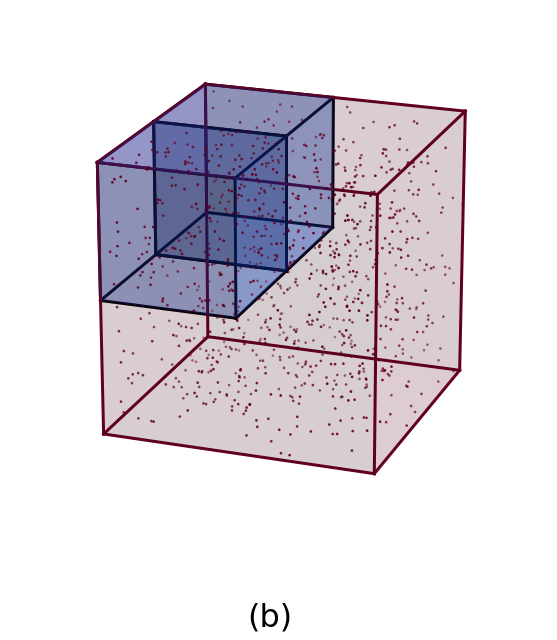

In [5]:
large_voxel = False
alpha = 0.2

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection='3d', elev=20, azim=-160, box_aspect=(1, 1, 1))

if large_voxel:
    models.plotting.plot_box(x=0, y=0, z=0, ds=1, ax=ax, alpha=alpha)
else:
    # models.plotting.plot_box(x=0, y=0, z=0, ds=0.5, ax=ax, alpha=alpha)
    # models.plotting.plot_box(x=0, y=0, z=0.5, ds=0.5, ax=ax, alpha=alpha)
    # models.plotting.plot_box(x=0, y=0.5, z=0, ds=0.5, ax=ax, alpha=alpha)
    models.plotting.plot_box(x=0, y=0.5, z=0.5, ds=0.5, ax=ax, alpha=alpha)
    # models.plotting.plot_box(x=0.5, y=0, z=0, ds=0.5, ax=ax, alpha=alpha)
    # models.plotting.plot_box(x=0.5, y=0, z=0.5, ds=0.5, ax=ax, alpha=alpha)
    # models.plotting.plot_box(x=0.5, y=0.5, z=0, ds=0.5, ax=ax, alpha=alpha)
    models.plotting.plot_box(x=0.5, y=0.5, z=0.5, ds=0.5, ax=ax, alpha=alpha)
models.plotting.plot_clumpy_ism_box(x=0, y=0, z=0, ds=1, ax=ax, N=1000, sa=0.1)
if large_voxel:
    fig.supxlabel('(a)', fontsize=32)
    fig.savefig('plots/uniform_RT-large.png')
else:
    fig.supxlabel('(b)', fontsize=32)
    fig.savefig('plots/uniform_RT-small.png')

### partially-filled voxel

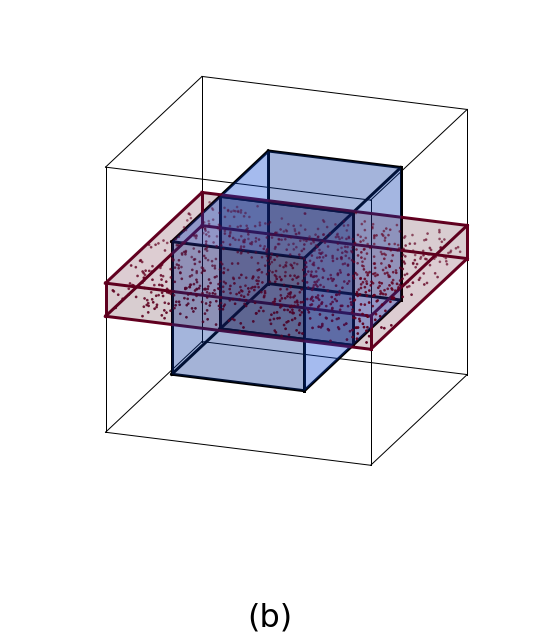

In [6]:
# %matplotlib widget

large_voxel = False
alpha = 0.2
d = 0.25

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection='3d', elev=20, azim=-160, box_aspect=(1, 1, 1))

models.plotting.plot_box(x=0, y=0, z=0, ds=1, ax=ax, alpha=0, lw=1)
if large_voxel:
    models.plotting.plot_box(x=0, y=0, z=0, ds=1, ax=ax, alpha=alpha)
else:
    models.plotting.plot_box(x=0, y=0.25, z=0.25, ds=0.5, ax=ax, alpha=alpha)
    models.plotting.plot_box(x=0.5, y=0.25, z=0.25, ds=0.5, ax=ax, alpha=alpha)
models.plotting.plot_clumpy_ism_box(x=0, y=0, z=0.5-d/4, ds=(1, 1, d/2), ax=ax, N=1000, sa=0.1)
ax.set_proj_type('ortho')
if large_voxel:
    fig.supxlabel('(a)', fontsize=32)
    fig.savefig('plots/partially-filled_RT-large.png')
else:
    fig.supxlabel('(b)', fontsize=32)
    fig.savefig('plots/partially-filled_RT-small.png')

## Calculation

Here we have a function to compute voxels with the required properties and print the intensity, emissivity, and absorption at the central velocities.
There are then functions to compute the radiative transfer in general for either the uniform case or when there is some variation along the line-of-sight.

### Functions

In [4]:
show_results = False

inGrid = False
test_fv = True
test_calc = True
test_pexp = False
test_opacity = False
suggested_calc = True

models.constants.dtype = np.float64

# Use these to change the voxel properties, which is necessary in the default mode.
voxel_parameters = {
                # Model parameters
                'voxel_size' : 1,
                 'molecules' : 'all',
                      'dust' : 'PAH',
          'clump_mass_range' : [[-1, 1]],
         'clump_mass_number' : [3],
               'clump_n_max' : [None],
            'velocity_range' : [-5, 5],
           'velocity_number' : 201,

                # Voxel properties
                  'velocity' : 0,
       'ensemble_dispersion' : 1,#1,
             'ensemble_mass' : [10**2],#7.15, 5.22#10**1,#0.8,
#               'volumeFactor' : [0.8, 0.2],
          'ensemble_density' : [10**5],#4.13, 4.17#10**5,#4.5,
                       'fuv' : 10**6,#1.13, 1.07#1.7,
                      # 'crir' : 2e-16,
    
                # initialisation
                    'dilled' : False,

                # calculation
            'suggested_calc' : True,
       'velocity_resolution' : 3,
    
                # logging
                   'verbose' : False,
                     'timed' : False,
                     'debug' : False
          }

emission_los = {}

In [5]:
def create_voxels(show_results=False, delta_s=(1, 0.5), dens=1, f_v=(1, 1), species=('C+ 1', 'CO 1'), 
                  f_fill=True, intensity=True, emissivity=True, absorption=True, **kwargs):

    t0 = time()

    for key in kwargs.keys():
        voxel_parameters[key] = kwargs[key]

    voxels = []
    for _ in range(len(delta_s)):
        voxel_parameters['ensemble_mass'] = f_v[_]*dens*delta_s[_]**3
        # if show_results:
        print(f"ensemble mass: {voxel_parameters['ensemble_mass']:.4f} M_sol")
        voxel_parameters['voxel_size'] = delta_s[_]
        t1 = time()
        vox = models.Voxel()
        vox.set_properties(**voxel_parameters)
        if show_results:
            print('initialised:', time()-t1)
        vox.calculate_emission()
        if show_results:
            print('calculated:', time()-t1)
        # vox.plot_clump_number(effective=True)
        # vox.plotMolecule(quantity='intensity', kind='slinear', molecule=['C+ 1', 'O 1', 'CO 4', 'CO 45'], moleculeName=[r'$\mathrm{C}^+ 1 \rightarrow 0$', r'$\mathrm{O} 1 \rightarrow 0$', r'$\mathrm{CO} 4 \rightarrow 3$', r'$\mathrm{CO} 45 \rightarrow 46$'])
        if show_results:
            vox.plot_molecule(quantity='intensity', kind='slinear', molecule=['C+ 1', 'C 1', 'CO 1', 'CO 5'], moleculeName=[r'$\mathrm{C}^+ 1 \rightarrow 0$', r'$\mathrm{C} 1 \rightarrow 0$', r'$\mathrm{CO} 1 \rightarrow 0$', r'$\mathrm{CO} 5 \rightarrow 4$'])
        # vox.plotSpectrum(quantity='intensity', kind='slinear', integrated=True)
        voxels.append(copy(vox))

        if show_results:
            print(time()-t0, '\n')
            print('\nDensity')
            print('---------------------')
            print('\n'.join(['Ensemble {}: {:.3e} cm^-3'.format(_+1, vox.get_density()[_]) for _ in range(models.constants.ensembles)]))
            print('\nClump Masses')
            print('---------------------')
            print('\n'.join(['Ensemble {}: {} M_sol'.format(_+1, models.constants.clump_log_mass[_].flatten()) for _ in range(models.constants.ensembles)]))
            print('\nClump Radii')
            print('---------------------')
            print('\n'.join(['Ensemble {}: {} pc'.format(_+1, models.masspoints.clump_radius[_].flatten()) for _ in range(models.constants.ensembles)]))
            print('\nVolume Filling Factor')
            print('---------------------')
            print('\n'.join(['Ensemble {}: {:.3f}'.format(_+1, vox.get_volume_filling_factor()[_]) for _ in range(models.constants.ensembles)]))
            print('\ntau_FUV')
            print('---------------------')
            print('\n'.join(['Ensemble {}: {:.3e}'.format(_+1, vox.get_taufuv()[_]) for _ in range(models.constants.ensembles)]))
            print()
    
    for key in emission_los.keys():
        emission_los[key].pop('intensity')
        emission_los[key].pop('epsilon')
        emission_los[key].pop('kappa')
    i_min = np.argmin(delta_s)
    i_vel = int(voxel_parameters['velocity_number']/2)
    # print(i_vel)
    for sp in species:
        i_sp = models.species.molecules.index(sp)
        emission_los[sp] = {}
        emission_los[sp]['intensity'] = tuple(vox.get_species_intensity(total=False, include_dust=True)[0][i_vel, i_sp] for vox in voxels)
        emission_los[sp]['epsilon'] = tuple(vox.get_species_emissivity(total=False, include_dust=True)[0][i_vel, i_sp] for vox in voxels)
        emission_los[sp]['kappa'] = tuple(vox.get_species_absorption(total=False, include_dust=True)[0][i_vel, i_sp] for vox in voxels)
            
    if f_fill:
        print('Volume-filling factor:' + ''.join(
            [f'\n  {_+1} -> {voxels[_].get_volume_filling_factor()[0]:.4e}' for _ in range(len(voxels))]
        ))
    if intensity:
        print('Maximum intensity:' + ''.join(
            [f'\n  {_+1}  ->  ' + ',  '.join(
                [f'{sp} {voxels[_].get_species_intensity(total=False, include_dust=True)[0][i_vel, models.species.molecules.index(sp)]:.4e}' 
                for sp in species]) for _ in range(len(voxels))]
        ))
    if emissivity:
        print('Maximum emissivity:' + ''.join(
            [f'\n  {_+1}  ->  ' + ',  '.join(
                [f'{sp} {voxels[_].get_species_emissivity(total=False, include_dust=True)[0][i_vel, models.species.molecules.index(sp)]:.4e}' 
                for sp in species]) for _ in range(len(voxels))]
        ))
    if absorption:
        print('Maximum absorption:' + ''.join(
            [f'\n  {_+1}  ->  ' + ',  '.join(
                [f'{sp} {voxels[_].get_species_absorption(total=False, include_dust=True)[0][i_vel, models.species.molecules.index(sp)]:.4e}' 
                for sp in species]) for _ in range(len(voxels))]
        ))

    return voxels

uniform medium calculation

In [6]:
def rt_uniform(N=1, ds=1, idx=0, f_vox=1, show_intensity=False):
    for sp in emission_los.keys():
        i = emission_los[sp]['intensity'][idx]
        e = emission_los[sp]['epsilon'][idx]
        k = emission_los[sp]['kappa'][idx]
        if f_vox != 1:
            k /= f_vox
            # k = -np.log(1/f_vox*np.exp(-k*ds)) / ds
            e /= f_vox
            i = e/k * (1 - np.exp(-k*ds))
            # i /= f_vox
            # e = i*k / (1 - np.exp(-k*ds))
        I = i
        if show_intensity:
            print('Intensity')
            print(f'  Voxel -> {i: .4e} K')
            print(f'     RT -> {e/k*(1-np.exp(-k*ds)): .4e} K')
        for _ in range(N-1):
            I = np.exp(-k*ds) * ( (e/k)*(np.exp(k*ds)-1) + I )
        print(f'The calculated intensity for {sp} is {I: .4e} K')
    return

two-layer calculation

In [7]:
def rt_multi_layer(ds=1, forward=False, f_vox=1):
    for sp in emission_los.keys():
        i = np.array(emission_los[sp]['intensity'])
        e = np.array(emission_los[sp]['epsilon'])
        k = np.array(emission_los[sp]['kappa'])
        if not forward:
            i = i[::-1]
            e = e[::-1]
            k = k[::-1]
        if f_vox != 1:
            for _ in range(i):
                e[_] = e[_]/f_vox
                k[_] = k[_]/f_vox
                i[_] = e[_]/k[_] * (1 - np.exp(-k[_]*ds))
        de = e[1:]-e[:-1]
        dk = k[1:]-k[:-1]
        I = i[0]
        for _ in range(len(de)):
            if dk[_] > 0:
                efun = np.exp((k[_]**2 - (k[_]+dk[_]*ds))/2/dk[_])*np.exp(-k[_]**2/2/dk[_])*erfi(k[_]/np.sqrt(2*dk[_])) \
                       - np.exp(-(k[_]+dk[_]*ds)**2/2/dk[_])*erfi((k[_]+dk[_]*ds)/np.sqrt(2*dk[_]))
            else:
                efun = np.exp((k[_]**2 - (k[_]+dk[_]*ds))/2/dk[_])*np.exp(np.abs(k[_]**2/2/dk[_]))*erfc(k[_]/np.sqrt(2*np.abs(dk[_]))) \
                       - np.exp(np.abs((k[_]+dk[_]*ds)**2/2/dk[_]))*erfc((k[_]+dk[_]*ds)/np.sqrt(2*np.abs(dk[_])))
            I = ( de[_]/dk[_]*(1-np.exp(-k[_]*ds-0.5*dk[_]*ds**2)) 
                 - (e[_]*dk[_]-k[_]*de[_])/dk[_] * np.sqrt(np.pi/2/np.abs(dk[_])) * efun ) \
                + I*np.exp(-k[_]*ds-0.5*dk[_]*ds**2)
        print(f'The calculated intensity for {sp} is {I:.4e} K')
    return

### Testing

In [13]:
# This takes volume-filling factor (of the ISM) as an argument
vox = create_voxels(delta_s=(2, 1, 0.5, 0.25), dens=1234, f_v=(0.125, 0.25, 0.5, 1), fuv=1e5, 
                    show_results=False, emissivity=True, absorption=True)

ensemble mass: 1234.0000 M_sol
ensemble mass: 308.5000 M_sol
ensemble mass: 77.1250 M_sol
ensemble mass: 19.2812 M_sol
Volume-filling factor:
  1 -> 6.2419e-02
  2 -> 1.2484e-01
  3 -> 2.4968e-01
  4 -> 4.9935e-01
Maximum intensity:
  1  ->  C+ 1 1.7321e+02,  CO 1 1.4746e+01
  2  ->  C+ 1 1.7361e+02,  CO 1 1.4760e+01
  3  ->  C+ 1 1.7583e+02,  CO 1 1.4909e+01
  4  ->  C+ 1 1.8125e+02,  CO 1 1.5111e+01
Maximum emissivity:
  1  ->  C+ 1 1.1747e+02,  CO 1 8.4314e+00
  2  ->  C+ 1 2.3576e+02,  CO 1 1.6883e+01
  3  ->  C+ 1 4.8118e+02,  CO 1 3.4166e+01
  4  ->  C+ 1 1.0084e+03,  CO 1 6.9436e+01
Maximum absorption:
  1  ->  C+ 1 3.2202e-01,  CO 1 1.3730e-01
  2  ->  C+ 1 6.4681e-01,  CO 1 2.7507e-01
  3  ->  C+ 1 1.3275e+00,  CO 1 5.5725e-01
  4  ->  C+ 1 2.8024e+00,  CO 1 1.1362e+00


In [14]:
rt_uniform(N=8, ds=0.25, idx=3, f_vox=1, show_intensity=False)  #this takes voxel-filling factor (of the model) as an argument

The calculated intensity for C+ 1 is  3.5850e+02 K
The calculated intensity for CO 1 is  5.4812e+01 K


In [15]:
rt_uniform(N=4, ds=0.5, idx=2, f_vox=0.5)  #this takes voxel-filling factor (of the model) as an argument

The calculated intensity for C+ 1 is  3.6069e+02 K
The calculated intensity for CO 1 is  5.4712e+01 K


In [16]:
rt_uniform(N=2, ds=1, idx=1, f_vox=0.25)  #this takes voxel-filling factor (of the model) as an argument

The calculated intensity for C+ 1 is  3.6244e+02 K
The calculated intensity for CO 1 is  5.4581e+01 K


In [17]:
rt_uniform(N=1, ds=2, idx=0, f_vox=0.125)  #this takes voxel-filling factor (of the model) as an argument

The calculated intensity for C+ 1 is  3.6267e+02 K
The calculated intensity for CO 1 is  5.4582e+01 K


In [21]:
rt_multi_layer(ds=0.5, forward=True)  #this takes voxel-filling factor (of the model) as an argument

The calculated intensity for C+ 1 is 1.5527e+00 K
The calculated intensity for CO 1 is 5.9218e-02 K


In [45]:
print((357.30-np.array([356.76, 356.80, 356.87]))/357.30)
print((52.407-np.array([52.300, 52.309, 52.344]))/52.407)

[0.00151134 0.00139938 0.00120347]
[0.00204171 0.00186998 0.00120213]


In [51]:
print((2.2451-4.5122)/2.2451)
print((0.076665-0.055815)/0.076665)

-1.009799118079373
0.2719624339659558
